# Implementing Portfolio Insurance (CPPI) and Drawdown Constraints
We'll start by implementing the basic Constant Proportion Portfolio Insurance dynamic risk budgeting algorithm, and test it against different portfolios.

In [2]:
import numpy as np

import pandas as pd
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', None)

import matplotlib.pyplot as plt

%load_ext autoreload
%autoreload 2
import kit as erk

In [3]:
# Load the industry returns and the total market index we previously created
ind_return = erk.get_ind_returns()
tmi_return = erk.get_total_market_index_returns()

The CPPI algorithm takes as input.
1. Returns of Risky asset
1. Returns of Safe asset
1. Initial wealth to invest 
1. Floor that should not be breaked

In [36]:
# Risky Assets Returns
risky_r = ind_return["2000":][["Steel", "Fin", "Beer"]]

# Safe Asset Return [0.03]
safe_r = pd.DataFrame().reindex_like(risky_r)
safe_r.values[:] = 0.03/12 

start = 1000 # Start at $1000
drawdown = 0.20 # set Floor to 80 percent of portfolio value.

The algorithm consist in.
1. Compute the cushion (asset value minus floor)
2. Compute the allocation (based on the multiplier)
3. Compute the new asset value

In [37]:
# Set up the CPPI parameters
dates = risky_r.index; n_steps = len(dates)
account_value = start; peak = start
floor_value = peak * (1 - drawdown)
m = 3

# Set up some DataFrames for recording values progress
account_history = pd.DataFrame().reindex_like(risky_r)
risky_w_history = pd.DataFrame().reindex_like(risky_r)
cushion_history = pd.DataFrame().reindex_like(risky_r)
floor_history = pd.DataFrame().reindex_like(risky_r)

In [38]:
for step in range(n_steps):
    # Risky Asset [E]
    cushion = (account_value - floor_value) / account_value
    risky_w = m*cushion
    risky_w = np.minimum(risky_w, 1); risky_w = np.maximum(risky_w, 0) # Constraints: No leveraged or Short Positions
    risky_alloc = account_value * risky_w

    # Safe Asset
    safe_w = 1 - risky_w
    safe_alloc = account_value * safe_w

    # Recompute the new account Value
    account_value = risky_alloc*(1 + risky_r.iloc[step])  +  safe_alloc*(1 + safe_r.iloc[step])

    # Update Max.Drawdown
    peak = np.maximum(peak, account_value)
    floor_value = peak * (1 - drawdown)

    # Save the histories
    cushion_history.iloc[step] = cushion
    risky_w_history.iloc[step] = risky_w
    account_history.iloc[step] = account_value
    floor_history.iloc[step] = floor_value

risky_wealth = start*(1+risky_r).cumprod()

Text(0.5, 1.0, 'CPPI on Beer Industry Fund')

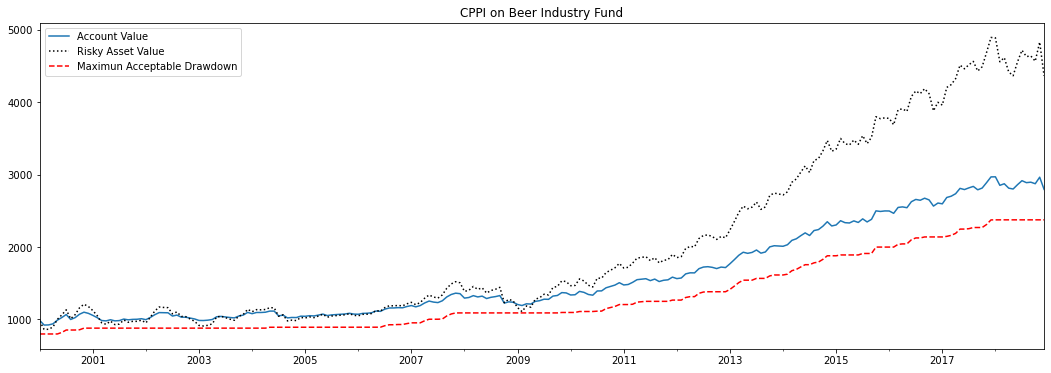

In [52]:
indx = "Beer"

fig, ax = plt.subplots(figsize=(18, 6))

account_history[indx].plot(ax = ax, label= 'Account Value')
risky_wealth[indx].plot(ax = ax, style="k:", label= 'Risky Asset Value')
floor_history[indx].plot(ax = ax, style='r--', label= 'Maximun Acceptable Drawdown')

ax.legend()
ax.set_title(f'CPPI on {indx} Industry Fund')

Text(0.5, 1.0, 'CPPI on Finance Industry Fund')

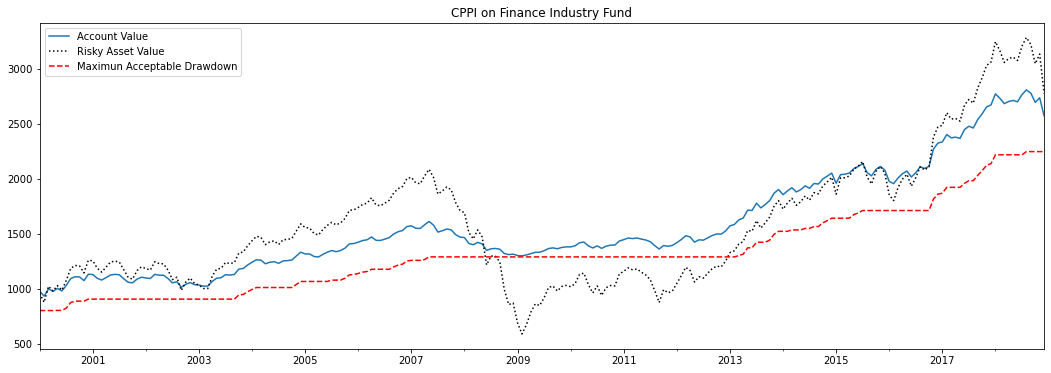

In [53]:
indx = "Fin"

fig, ax = plt.subplots(figsize=(18, 6))

account_history[indx].plot(ax = ax, label= 'Account Value')
risky_wealth[indx].plot(ax = ax, style="k:", label= 'Risky Asset Value')
floor_history[indx].plot(ax = ax, style='r--', label= 'Maximun Acceptable Drawdown')

ax.legend()
ax.set_title(f'CPPI on Finance Industry Fund')

Text(0.5, 1.0, 'CPPI on Steel Industry Fund')

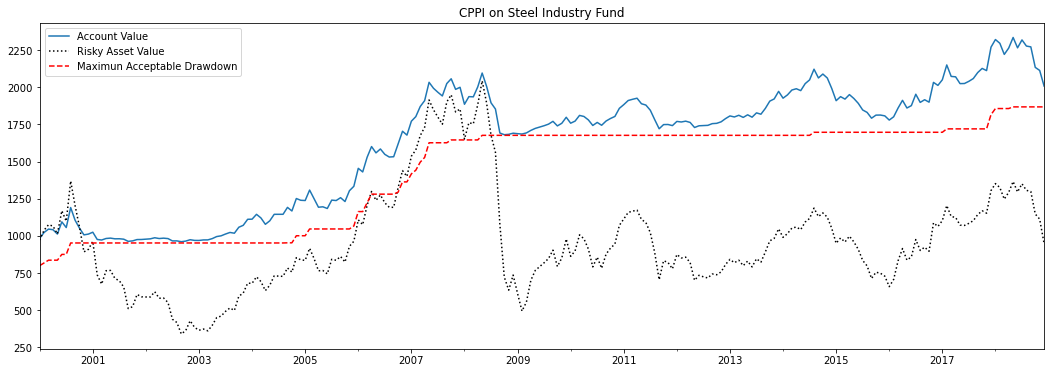

In [54]:
indx = "Steel"

fig, ax = plt.subplots(figsize=(18, 6))

account_history[indx].plot(ax = ax, label= 'Account Value')
risky_wealth[indx].plot(ax = ax, style="k:", label= 'Risky Asset Value')
floor_history[indx].plot(ax = ax, style='r--', label= 'Maximun Acceptable Drawdown')

ax.legend()
ax.set_title(f'CPPI on {indx} Industry Fund')

<AxesSubplot:>

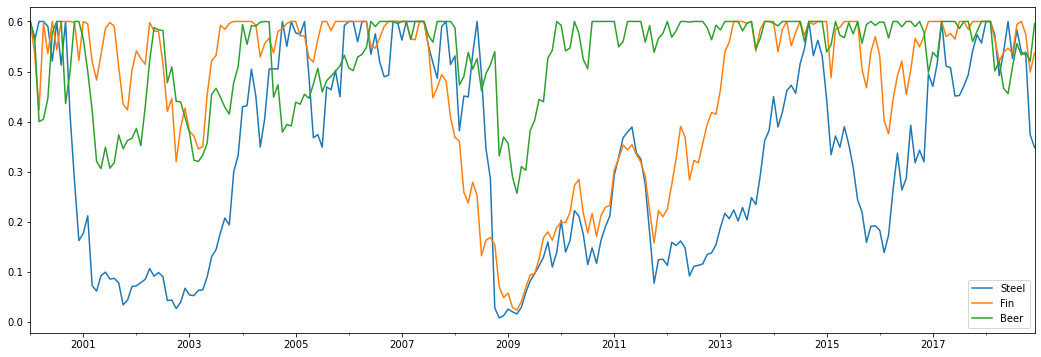

In [56]:
risky_w_history.plot(figsize=(18,6))

Let's put this all into a new function which we can add to our `kit.py`:

```python
def run_cppi(risky_r = None, safe_r = None, m = 3, start=1000, floor = 0.8, riskfree_rate = 0.03, drawdown = None):
    """
    Run a backtest of the CPPI strategy, given a set of returns for the risky asset
    Returns a dictionary containing: Asset Value History, Risk Budget History, Risky Weight History
    """
    # set up the CPPI parameters
    dates = risky_r.index
    n_steps = len(dates)
    account_value = start
    floor_value = start*floor

    if isinstance(risky_r, pd.Series): 
        risky_r = pd.DataFrame(risky_r, columns=["R"])

    if safe_r is None:
        safe_r = pd.DataFrame().reindex_like(risky_r)
        safe_r.values[:] = riskfree_rate/12

    if drawdown is not None:
        peak = np.maximum(peak, account_value)
        floor_value = peak*(1-drawdown)

    # set up some DataFrames for saving intermediate values
    account_history = pd.DataFrame().reindex_like(risky_r)
    risky_w_history = pd.DataFrame().reindex_like(risky_r)
    cushion_history = pd.DataFrame().reindex_like(risky_r)
    
    for step in range(n_steps):
        cushion = (account_value - floor_value)/account_value
        risky_w = m*cushion
        risky_w = np.minimum(risky_w, 1)
        risky_w = np.maximum(risky_w, 0)
        safe_w = 1-risky_w
        risky_alloc = account_value*risky_w
        safe_alloc = account_value*safe_w
        # recompute the new account value at the end of this step
        account_value = risky_alloc*(1+risky_r.iloc[step]) + safe_alloc*(1+safe_r.iloc[step])
        # save the histories for analysis and plotting
        cushion_history.iloc[step] = cushion
        risky_w_history.iloc[step] = risky_w
        account_history.iloc[step] = account_value


    risky_wealth = start*(1+risky_r).cumprod()

    backtest_result = {
        "Wealth": account_history,
        "Risky Wealth": risky_wealth, 
        "Risk Budget": cushion_history,
        "Risky Allocation": risky_w_history,
        "m": m,
        "start": start,
        "floor": floor,
        "risky_r":risky_r,
        "safe_r": safe_r
    }

    return backtest_result

```

Let's also write a convenience function to provide summary statistics on a set of returns:

```python

def summary_stats(r, riskfree_rate=0.03):
    """
    Return a DataFrame that contains aggregated summary stats for the returns in the columns of r
    """
    ann_r = r.aggregate(annualize_rets, periods_per_year=12)
    ann_vol = r.aggregate(annualize_vol, periods_per_year=12)
    ann_sr = r.aggregate(sharpe_ratio, riskfree_rate=riskfree_rate, periods_per_year=12)
    dd = r.aggregate(lambda r: drawdown(r).Drawdown.min())
    skew = r.aggregate(skewness)
    kurt = r.aggregate(kurtosis)
    cf_var5 = r.aggregate(var_gaussian, modified=True)
    hist_cvar5 = r.aggregate(cvar_historic)
    
    return pd.DataFrame({
        "Annualized Return": ann_r,
        "Annualized Vol": ann_vol,
        "Skewness": skew,
        "Kurtosis": kurt,
        "Cornish-Fisher VaR (5%)": cf_var5,
        "Historic CVaR (5%)": hist_cvar5,
        "Sharpe Ratio": ann_sr,
        "Max Drawdown": dd
    })

```


In [61]:
btr = erk.run_cppi(ind_return["2007":][["Steel", "Fin", "Beer"]])

# Stats of the Risky Assets
erk.summary_stats(btr["Risky Wealth"].pct_change().dropna())

,Annualized Return,Annualized Vol,Skewness,Kurtosis,Cornish-Fisher VaR (5%),Historic CVaR (5%),Sharpe Ratio,Max Drawdown
Steel,-0.039660,0.306407,-0.459951,4.782828,0.152288,0.203837,-0.221642,-0.758017
Fin,0.027364,0.212204,-0.695200,4.621401,0.105744,0.149862,-0.012370,-0.718465
Beer,0.111554,0.127971,-0.670797,4.650878,0.056497,0.077388,0.620132,-0.271368


In [62]:
# Stats of our CPPI Portfolio
erk.summary_stats(btr["Wealth"].pct_change().dropna()) 

,Annualized Return,Annualized Vol,Skewness,Kurtosis,Cornish-Fisher VaR (5%),Historic CVaR (5%),Sharpe Ratio,Max Drawdown
Steel,-0.014490,0.126906,-1.554266,11.668243,0.068652,0.098467,-0.341351,-0.404132
Fin,0.054690,0.109579,-0.254976,5.589082,0.047503,0.068951,0.219159,-0.216868
Beer,0.101518,0.114363,-0.743585,4.527865,0.051074,0.069081,0.608531,-0.217280
